# Import Packages

In [1]:
# Import requests and BeautifulSoup libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt
import re
import urllib.request

In [2]:
!pip3 freeze > requirements.txt  # Python3

'pip3' is not recognized as an internal or external command,
operable program or batch file.


# Initialization

In [3]:
# Define the URL of the website
url = "https://www.phei.co.id/Data/HPW-dan-Imbal-Hasil"

response = requests.get(url)
html_response = response.content
text_find = response.text
df_list = pd.read_html(html_response)

In [4]:
start_ = re.search('<div id="dnn_ctr1477_GovernmentBondBenchmark_idIGSYC_tdTgl">', text_find).start()
date_yc = text_find[start_ :100+start_]
date_yc = date_yc.split(' ')[-2]
split = date_yc.find('<')
clean_date = date_yc[:split]
clean_date

'26-Maret-2025'

In [5]:
if int(clean_date.split('-')[0]) < 10:
    cleaner_date = clean_date.split('-')
    cleaner_date[0] = '0' + cleaner_date[0]
    clean_date = '-'.join(cleaner_date)
clean_date

'26-Maret-2025'

In [6]:
dict_month_number = {"Januari": "01", 
                     "Februari": "02", 
                     "Maret": "03", 
                     "April": "04", 
                     "Mei": "05", 
                     "Juni": "06", 
                     "Juli": "07", 
                     "Agustus": "08", 
                     "September": "09", 
                     "Oktober": "10", 
                     "November": "11", 
                     "Desember": "12",}

In [7]:
sub_path = f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}'
try:
    os.makedirs(sub_path)
    print(f"Folder {sub_path} created!")
except FileExistsError:
    print(f"Folder {sub_path} already exists")

sub_path_image = sub_path+'/image'
try:
    os.makedirs(sub_path_image)
    print(f"Folder {sub_path_image} created!")
except FileExistsError:
    print(f"Folder {sub_path_image} already exists")

sub_path_py_image = sub_path+'/py-image'
try:
    os.makedirs(sub_path_py_image)
    print(f"Folder {sub_path_py_image} created!")
except FileExistsError:
    print(f"Folder {sub_path_py_image} already exists")

Folder 2025-03-Maret already exists
Folder 2025-03-Maret/image already exists
Folder 2025-03-Maret/py-image already exists


# Saving Image as PDF

In [8]:
# Save image from Website
img_location_url = text_find[re.search('ChartPic', text_find).start():re.search('ChartPic', text_find).start()+200].split(' ')[0][:-1]
imgURL = "https://www.phei.co.id/"+img_location_url
urllib.request.urlretrieve(imgURL,f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/image/{clean_date}.jpeg')


('2025-03-Maret/image/26-Maret-2025.jpeg',
 <http.client.HTTPMessage at 0x1450ef551b0>)

In [9]:
def prepare_data(df, type_df):
    copy_df = df.copy()
    copy_df.drop(columns = copy_df.columns[[0, -1]], inplace = True)
    copy_df['type'] = type_df
    return copy_df

# Saving Underlying Bond Data

In [10]:
sbn_data = prepare_data(df_list[2], 'sbn')
sbsn_data = prepare_data(df_list[3], 'sbsn')
retail_data= prepare_data(df_list[4], 'retail')

bond_data = pd.concat((sbn_data, 
                             sbsn_data,
                             retail_data), axis = 0).reset_index(drop = True)

In [11]:
bond_data.iloc[:,1] /= 100
bond_data.iloc[:,2:-1] /= 10000
bond_data

,Series,TTM (Y),Today Yield (%),Today Price (%),Yesterday Yield (%),Yesterday Price (%),Coupon(%),type
0,FR0104,5.31,6.8401,98.4946,6.9660,97.9479,6.500,sbn
1,FR0103,10.31,7.1392,97.1800,7.2047,96.7174,6.750,sbn
2,FR0106,15.40,7.1772,99.5080,7.2319,99.0067,7.125,sbn
3,FR0107,20.40,7.1900,99.2990,7.2373,98.8020,7.125,sbn
4,PBS003,1.81,6.7779,98.6860,6.7626,98.7098,6.000,sbsn
5,PBS030,3.31,6.7178,97.5264,6.7248,97.5042,5.875,sbsn
6,PBS034,14.23,6.8853,96.5271,6.8914,96.4732,6.500,sbsn
7,PBS038,24.74,7.1848,96.4266,7.1869,96.4019,6.875,sbsn
8,ORI022,0.56,6.5035,99.6994,6.4674,99.7177,5.950,retail
9,ORI023T3,1.30,6.6524,99.0625,6.6452,99.0697,5.900,retail


In [12]:
bond_data.to_excel(f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/Bond-Data-{clean_date}.xlsx', 
            sheet_name=clean_date)

# Calculating Spot Rate and Saving Spot Rate Data

In [13]:
df = pd.concat((df_list[0],df_list[1]), axis = 0)[['Tenor Year', 'Today']]
df['Tenor Year'] /= 10
df['Today'] /= 1e6
df.rename(columns = {'Today': 'IBPA Yield'}, inplace = True)
df.set_index('Tenor Year', inplace=True)

In [14]:
def spot_rate(df):
    spot_data = df.values.copy()
    for j in range(2,df.shape[0]):
        minus = 0
        for k in range(1,j):
            minus -= spot_data[j]/(1+spot_data[k])**k
        spot_data[j] = ((1+df.iloc[j])/(1+minus))**(1/j)-1
    return spot_data

In [15]:
df['Spot-Rate'] = spot_rate(df)

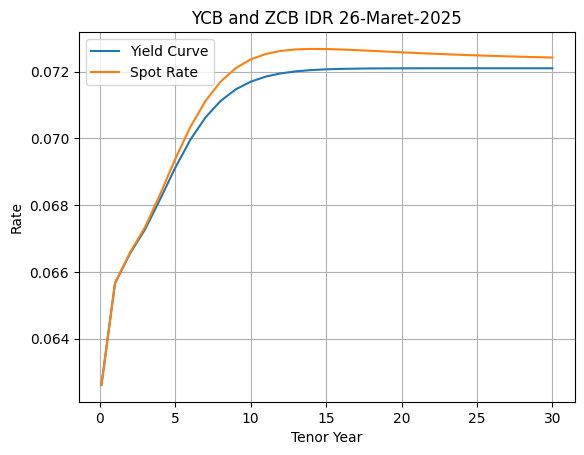

In [16]:
plt.plot(df.index, df['IBPA Yield'], label = 'Yield Curve')
plt.plot(df.index, df['Spot-Rate'], label = 'Spot Rate')
plt.xlabel('Tenor Year')
plt.ylabel('Rate')
plt.legend()
plt.title(f'YCB and ZCB IDR {clean_date}')
plt.grid()
plt.savefig(f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/py-image/{clean_date}.jpeg')
plt.show()

In [17]:
df.to_excel(f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/Yield-Curve-{clean_date}.xlsx', 
            sheet_name=clean_date)

# Saving Corporate Bond Data

In [18]:
corporate_bond = df_list[5].iloc[:,1:-1]
corporate_bond.iloc[:,0] /= 10
corporate_bond.iloc[:,1:] /= 1e6
corporate_bond


,Tenor(Year),IGS,AAA,AA,A,BBB
0,0.1,0.062613,0.065402,0.067438,0.074365,0.085566
1,1.0,0.065663,0.068528,0.071801,0.086806,0.098292
2,2.0,0.066556,0.069422,0.073708,0.090567,0.103835
3,3.0,0.067281,0.070240,0.075195,0.093114,0.107723
4,4.0,0.068184,0.071386,0.076776,0.095621,0.111248
5,5.0,0.069127,0.072666,0.078346,0.097783,0.114284
6,6.0,0.069963,0.073866,0.079745,0.099402,0.116668
7,7.0,0.070630,0.074870,0.080892,0.100501,0.118400
8,8.0,0.071123,0.075648,0.081774,0.101195,0.119586
9,9.0,0.071469,0.076219,0.082421,0.101613,0.120364


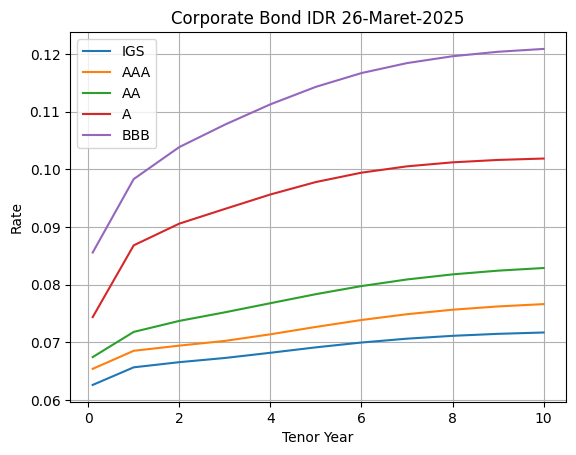

In [19]:
plt.plot(corporate_bond.iloc[:,0], corporate_bond.iloc[:,1:], label = corporate_bond.columns[1:])
plt.legend()
plt.xlabel('Tenor Year')
plt.ylabel('Rate')
plt.title(f'Corporate Bond IDR {clean_date}')
plt.grid()
plt.savefig(f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/py-image/Corporate Bond IDR-{clean_date}.jpeg')
plt.show()

In [20]:
corporate_bond.to_excel(f'{clean_date.split("-")[2]}-{dict_month_number.get(clean_date.split("-")[1])}-{clean_date.split("-")[1]}/Corporate-Bond-{clean_date}.xlsx', 
            sheet_name=clean_date)